In [1]:
'''
AI model:
Train AI with states as features and next move (0-17) as label. That is the last move from the scramble

Solver:
For each state, do
(0. Evaluate current state)
1. For each alg up to length k, evaluate state.
2. Pick the n "best" algs from step 1, and repeat step (0)1-2 for from the state caused by applying the first move
(3.) Table look up for all algs of length m (=5/6/7)
'''

'\nAI model:\nTrain AI with states as features and next move (0-17) as label. That is the last move from the scramble\n\nSolver:\nFor each state, do\n(0. Evaluate current state)\n1. For each alg up to length k, evaluate state.\n2. Pick the n "best" algs from step 1, and repeat step (0)1-2 for from the state caused by applying the first move\n(3.) Table look up for all algs of length m (=5/6/7)\n'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

import random
import time

In [3]:
%run ../cube/Cube.ipynb

Support algs imported!
Cube initiated


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
def cube_to_tensor(cube, long_repr = True):
    '''
    removes center stickers, top corners
    (should I remove 1 whole corner and 3 edge stickers as well?)
    '''
    state = cube.state.tolist()
    short_state = state[0:4]
    short_state += state[5:13]
    short_state += state[14:22]
    short_state += state[23:31]
    short_state += state[32:36]
    short_state += [state[37],state[39],state[41],state[43],state[46],state[48],state[50],state[52]]
    if long_repr:
        long_state = np.zeros(len(short_state)*6)
        for i in range(len(short_state)):
            long_state[6*i:6*i+6] = np.array([0]*(short_state[i]-1) + [1] + [0]*(6-short_state[i]))
        tensor = torch.from_numpy(np.array(long_state, dtype=np.float32))
        return tensor.to(device)
    tensor = torch.from_numpy(np.array(long_state, dtype=np.float32))
    return tensor.to(device)

cuda


In [5]:
# Define the network architecture
class SimpleNetwork(nn.Module):
    def __init__(self):
        super(SimpleNetwork, self).__init__()
        self.fc1 = nn.Linear(240, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 18)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Create an instance of the network
network = SimpleNetwork()
network = network.to(device)


In [21]:
class ResnetModel(nn.Module):
    def __init__(self, state_dim: int, h1_dim: int, resnet_dim: int, num_resnet_blocks: int,
                 out_dim: int, batch_norm: bool):
        super().__init__()
        self.state_dim: int = state_dim
        self.blocks = nn.ModuleList()
        self.num_resnet_blocks: int = num_resnet_blocks
        self.batch_norm = batch_norm

        # first two hidden layers
        self.fc1 = nn.Linear(self.state_dim, h1_dim)

        if self.batch_norm:
            self.bn1 = nn.BatchNorm1d(h1_dim)

        self.fc2 = nn.Linear(h1_dim, resnet_dim)

        if self.batch_norm:
            self.bn2 = nn.BatchNorm1d(resnet_dim)

        # resnet blocks
        for block_num in range(self.num_resnet_blocks):
            if self.batch_norm:
                res_fc1 = nn.Linear(resnet_dim, resnet_dim)
                res_bn1 = nn.BatchNorm1d(resnet_dim)
                res_fc2 = nn.Linear(resnet_dim, resnet_dim)
                res_bn2 = nn.BatchNorm1d(resnet_dim)
                self.blocks.append(nn.ModuleList([res_fc1, res_bn1, res_fc2, res_bn2]))
            else:
                res_fc1 = nn.Linear(resnet_dim, resnet_dim)
                res_fc2 = nn.Linear(resnet_dim, resnet_dim)
                self.blocks.append(nn.ModuleList([res_fc1, res_fc2]))

        # output
        self.fc_out = nn.Linear(resnet_dim, out_dim)

    def forward(self, states_nnet):
        x = states_nnet

        # preprocess input
        x = x.float()

        # first two hidden layers
        x = self.fc1(x)
        if self.batch_norm:
            x = self.bn1(x)

        x = F.relu(x)
        x = self.fc2(x)
        if self.batch_norm:
            x = self.bn2(x)

        x = F.relu(x)

        # resnet blocks
        for block_num in range(self.num_resnet_blocks):
            res_inp = x
            if self.batch_norm:
                x = self.blocks[block_num][0](x)
                x = self.blocks[block_num][1](x)
                x = F.relu(x)
                x = self.blocks[block_num][2](x)
                x = self.blocks[block_num][3](x)
            else:
                x = self.blocks[block_num][0](x)
                x = F.relu(x)
                x = self.blocks[block_num][1](x)

            x = F.relu(x + res_inp)

        # output
        x = self.fc_out(x)
        return x
    
network = ResnetModel(240, 4096, 1024, 5, 18, False)
network = network.to(device)

In [141]:
# Train
# trains by making a "small" dataset and training on it 5 times. Repeat N times
# Define a loss function and optimizer
criterion = nn.MSELoss() #nn.CrossEntropyLoss() MSELoss

optimizer = optim.SGD(network.parameters(), lr=0.01) #SGD
u = 0.99

# optimizer = optimizer.to(device)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.005)
# scheduler = lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01, step_size_up=100, cycle_momentum=False)


N = 5000
dataset_size = 5000
num_epochs = 1
data_exp = 1
min_alg_length = 7
max_alg_length = 15
nr_of_algs = dataset_size//(max_alg_length - min_alg_length + 1) # gives approx. dataset_size nr of data points
print(f"Training on {N}*{dataset_size} data points {num_epochs} times, totaling {N*dataset_size*num_epochs} data points.")


Training on 5000*5000 data points 1 times, totaling 25000000 data points.


In [137]:
def random_dataset(dataset_size, data_exp, min_alg_length, max_alg_length):
    # Define a dataset (input-output pairs)
    dataset = []
    for i in range(dataset_size):
        length = gen_random_length(data_exp, min_alg_length, max_alg_length)
        alg = gen_random_alg(length)
        cube = Cube(0)
        cube.apply_moves(alg)
        dataset.append((cube_to_tensor(cube),torch.tensor([moves.index(inverse_alg(alg.split(" ")[-1]))])))
    return dataset

def smart_dataset(nr_of_algs, data_exp, min_alg_length, max_alg_length):
    # total number of data points: nr_of_algs*(max_alg_length - min_alg_length + 1)
    dataset = []
    for i in range(nr_of_algs):
        alg = gen_random_alg(max_alg_length)
        sub_algs = []
        cube = Cube()
        cube.apply_moves(alg)
        for j in range(max_alg_length-1,min_alg_length-2,-1):
            inv = inverse_alg(alg.split(" ")[j])
            target = torch.tensor([moves.index(inv)])
            target = target.to(device)
            dataset.append((cube_to_tensor(cube),target))
            cube.apply_moves(inv)
    return dataset

# r_dataset = random_dataset(dataset_size, data_exp, min_alg_length, max_alg_length)
# s_dataset = smart_dataset(nr_of_algs, data_exp, min_alg_length, max_alg_length)
# len(r_dataset),len(s_dataset)

In [146]:
network.train()

t = time.time()
for rep in range(N):
    dataset = smart_dataset(nr_of_algs, data_exp, min_alg_length, max_alg_length)
    print(f"Dataset {rep+1} created")
    
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        i = 0
        for input_data, target in dataset:
            # Forward pass
            output = network(input_data)

            # Encode the target as class probabilities
            target_onehot = F.one_hot(target, num_classes=18).float().squeeze()

            # Compute the loss
            print(output, target_onehot)
            loss = criterion(output, target_onehot)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
#             scheduler.step()

            total_loss += loss.item()
            i+=1

        # Print average loss for the epoch
        average_loss = total_loss / len(dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss (x100): {100*average_loss:.4f}, Time Spent: {int(time.time()-t)}s")
    print(f"{rep+1}/{N} done, time elapsed since training start: {int(time.time()-t)}s")
    optimizer.param_groups[0]['lr'] *= u
    print("Next Learning Rate:",optimizer.param_groups[0]['lr'])

network.eval()

Dataset 1 created
tensor([0.0529, 0.0521, 0.0471, 0.0583, 0.0564, 0.0368, 0.0606, 0.0516, 0.0535,
        0.0755, 0.0743, 0.0492, 0.0591, 0.0595, 0.0548, 0.0608, 0.0572, 0.0493],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.0593, 0.0530, 0.0508, 0.0333, 0.0350, 0.0388, 0.0802, 0.0645, 0.0632,
        0.0497, 0.0490, 0.0483, 0.0742, 0.0735, 0.0547, 0.0634, 0.0577, 0.0526],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       device='cuda:0')
tensor([0.0606, 0.0616, 0.0568, 0.0338, 0.0424, 0.0303, 0.1111, 0.0804, 0.0651,
        0.0432, 0.0438, 0.0316, 0.0660, 0.0692, 0.0473, 0.0488, 0.0401, 0.0589],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.0640, 0.0660, 0.0444, 0.0401, 

tensor([0.0030, 0.0111, 0.1107, 0.0038, 0.0092, 0.0811, 0.0464, 0.0325, 0.0727,
        0.0926, 0.0993, 0.0538, 0.0507, 0.0513, 0.0768, 0.0599, 0.0608, 0.0941],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.0041, 0.0104, 0.0517, 0.0837, 0.0738, 0.0765, 0.0332, 0.0535, 0.0748,
        0.0695, 0.0633, 0.0466, 0.0444, 0.0349, 0.0681, 0.1152, 0.1089, 0.0296],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.0071, 0.0062, 0.0824, 0.0779, 0.0643, 0.0761, 0.0912, 0.0951, 0.0554,
        0.0475, 0.0396, 0.0473, 0.0388, 0.0404, 0.0532, 0.0711, 0.0660, 0.0426],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.0103, 0.0019, 0.0803, 0.0723, 0.0690, 0.0792, 0.

tensor([0.0236, 0.0297, 0.0599, 0.0686, 0.0747, 0.0430, 0.0751, 0.0591, 0.0715,
        0.0251, 0.0264, 0.0293, 0.0555, 0.0608, 0.0565, 0.0837, 0.0793, 0.0662],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       device='cuda:0')
tensor([0.0062, 0.0128, 0.0417, 0.1262, 0.1418, 0.0236, 0.0857, 0.0834, 0.0282,
        0.0068, 0.0083, 0.0141, 0.0660, 0.0919, 0.0221, 0.0770, 0.0834, 0.0457],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       device='cuda:0')
tensor([ 0.0110,  0.0092,  0.0488,  0.4548,  0.4691, -0.0177,  0.0562,  0.0572,
        -0.0257, -0.0431, -0.0409, -0.0178,  0.0300,  0.0499, -0.0290,  0.0035,
         0.0045, -0.0320], device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([-0.0081, -0.0087,  0.0452, -0.0

tensor([0.0872, 0.0767, 0.0464, 0.0433, 0.0538, 0.0605, 0.0119, 0.0211, 0.0460,
        0.0306, 0.0448, 0.0454, 0.0528, 0.0575, 0.0680, 0.0812, 0.0802, 0.0713],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.0312, 0.0386, 0.0615, 0.0940, 0.1038, 0.0577, 0.0188, 0.0132, 0.0360,
        0.0402, 0.0410, 0.0353, 0.0456, 0.0515, 0.0438, 0.1113, 0.1156, 0.0436],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       device='cuda:0')
tensor([0.0191, 0.0269, 0.0681, 0.1154, 0.1155, 0.0440, 0.0439, 0.0405, 0.0342,
        0.0326, 0.0308, 0.0184, 0.0491, 0.0561, 0.0432, 0.1033, 0.1112, 0.0391],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.0165, 0.0139, 0.0342, 0.1259, 0.1231, 0.0380, 0.

tensor([0.0617, 0.0527, 0.0426, 0.1041, 0.1418, 0.0476, 0.0188, 0.0148, 0.0467,
        0.0349, 0.0527, 0.0390, 0.0619, 0.0878, 0.0504, 0.0375, 0.0364, 0.0690],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.0501, 0.0545, 0.0490, 0.0363, 0.0530, 0.0604, 0.0280, 0.0237, 0.0722,
        0.0572, 0.0643, 0.0507, 0.0890, 0.1040, 0.0648, 0.0406, 0.0381, 0.0710],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.0594, 0.0633, 0.0514, 0.0420, 0.0399, 0.0669, 0.0412, 0.0431, 0.1009,
        0.0408, 0.0450, 0.0559, 0.0553, 0.0503, 0.1047, 0.0340, 0.0390, 0.0776],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.0296, 0.0405, 0.0472, 0.0820, 0.0837, 0.0553, 0.

tensor([0.0466, 0.0439, 0.0712, 0.0626, 0.0707, 0.0675, 0.0530, 0.0534, 0.0565,
        0.0379, 0.0388, 0.0582, 0.0474, 0.0551, 0.0714, 0.0583, 0.0561, 0.0616],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       device='cuda:0')
tensor([0.0481, 0.0509, 0.0974, 0.0377, 0.0516, 0.0510, 0.0679, 0.0420, 0.0581,
        0.0375, 0.0378, 0.0407, 0.0486, 0.0551, 0.0792, 0.0614, 0.0574, 0.0805],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.0484, 0.0344, 0.0555, 0.0477, 0.0733, 0.0484, 0.0315, 0.0289, 0.0531,
        0.0641, 0.0841, 0.0556, 0.0572, 0.0826, 0.0642, 0.0459, 0.0456, 0.0826],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       device='cuda:0')
tensor([0.0359, 0.0200, 0.0451, 0.0839, 0.1110, 0.0408, 0.

tensor([ 0.0214,  0.0085,  0.0600,  0.4486,  0.4394,  0.0214, -0.0232, -0.0114,
        -0.0097, -0.0172, -0.0057, -0.0060,  0.0157,  0.0154,  0.0051,  0.0229,
         0.0258, -0.0101], device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.0822, 0.0594, 0.0446, 0.0690, 0.0730, 0.0442, 0.1011, 0.0932, 0.0473,
        0.0261, 0.0410, 0.0428, 0.0541, 0.0638, 0.0531, 0.0370, 0.0263, 0.0471],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.0875, 0.0662, 0.0613, 0.0451, 0.0457, 0.0559, 0.0843, 0.0752, 0.0421,
        0.0640, 0.0655, 0.0520, 0.0428, 0.0536, 0.0530, 0.0325, 0.0233, 0.0548],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.0679, 0.0534, 0.0559, 0.0794,

tensor([0.0614, 0.0478, 0.0301, 0.0408, 0.0395, 0.0543, 0.0580, 0.0739, 0.0885,
        0.0488, 0.0519, 0.0733, 0.0411, 0.0473, 0.0756, 0.0597, 0.0628, 0.0590],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.0429, 0.0351, 0.0558, 0.0551, 0.0453, 0.0605, 0.0605, 0.0845, 0.0529,
        0.0556, 0.0487, 0.0730, 0.0307, 0.0415, 0.0617, 0.0808, 0.0909, 0.0382],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.0235, 0.0441, 0.0704, 0.0408, 0.0328, 0.0772, 0.0447, 0.0728, 0.0493,
        0.0829, 0.0728, 0.0479, 0.0483, 0.0430, 0.0761, 0.0593, 0.0743, 0.0526],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.0252, 0.0449, 0.0770, 0.0481, 0.0476, 0.0641, 0.

tensor([0.0680, 0.0556, 0.0457, 0.0404, 0.0487, 0.0363, 0.0971, 0.0924, 0.0758,
        0.0380, 0.0397, 0.0921, 0.0463, 0.0641, 0.0484, 0.0291, 0.0316, 0.0435],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.1313, 0.1256, 0.0423, 0.0359, 0.0370, 0.0466, 0.1038, 0.0901, 0.0519,
        0.0169, 0.0265, 0.0280, 0.0637, 0.0738, 0.0540, 0.0173, 0.0227, 0.0476],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.1146, 0.0888, 0.0386, 0.0319, 0.0309, 0.0646, 0.0698, 0.0722, 0.0752,
        0.0250, 0.0367, 0.0470, 0.0500, 0.0569, 0.0679, 0.0332, 0.0347, 0.0696],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.0246, 0.0243, 0.0609, 0.0220, 0.0347, 0.0722, 0.

tensor([0.0456, 0.0338, 0.0454, 0.0506, 0.0562, 0.0673, 0.0722, 0.0849, 0.0658,
        0.0212, 0.0280, 0.0877, 0.0680, 0.0670, 0.0529, 0.0479, 0.0437, 0.0493],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       device='cuda:0')
tensor([-0.0125, -0.0118, -0.0274,  0.0116,  0.0070,  0.0139,  0.4001,  0.4135,
         0.0291,  0.0238,  0.0270,  0.1040,  0.0243,  0.0237,  0.0052, -0.0049,
        -0.0140, -0.0099], device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([ 0.0429,  0.0455,  0.0873,  0.0535,  0.0392,  0.0858, -0.0014,  0.0044,
         0.0854,  0.0020, -0.0007,  0.0914,  0.1318,  0.1261,  0.0629,  0.0499,
         0.0424,  0.0713], device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.1138, 0.12

tensor([ 0.4011,  0.3745,  0.0268,  0.0192,  0.0022,  0.0519,  0.0239,  0.0006,
        -0.0071,  0.0088,  0.0235, -0.0062,  0.0588,  0.0690, -0.0160, -0.0031,
        -0.0111,  0.0092], device='cuda:0', grad_fn=<AddBackward0>) tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([ 0.0188, -0.0111,  0.0678, -0.0027,  0.0074,  0.0449,  0.0960,  0.0670,
         0.0731,  0.0299,  0.0463,  0.0607,  0.1157,  0.1445,  0.0560,  0.0496,
         0.0439,  0.0784], device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       device='cuda:0')
tensor([ 0.0106,  0.0024,  0.0944, -0.0096, -0.0101,  0.0828,  0.0527,  0.0412,
         0.0825,  0.0177,  0.0282,  0.0671,  0.0847,  0.0967,  0.0487,  0.1337,
         0.1240,  0.0512], device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
t

tensor([0.0420, 0.0340, 0.0621, 0.1045, 0.1118, 0.0453, 0.0523, 0.0341, 0.0463,
        0.1025, 0.1218, 0.0409, 0.0098, 0.0178, 0.0567, 0.0123, 0.0090, 0.0647],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.0746, 0.0725, 0.0545, 0.0860, 0.0754, 0.0376, 0.0660, 0.0679, 0.0532,
        0.0417, 0.0386, 0.0628, 0.0302, 0.0279, 0.0525, 0.0629, 0.0608, 0.0508],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.0834, 0.0842, 0.0540, 0.0196, 0.0250, 0.0354, 0.0683, 0.0691, 0.0426,
        0.0572, 0.0585, 0.0569, 0.0488, 0.0575, 0.0532, 0.0696, 0.0711, 0.0499],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.0634, 0.0602, 0.0533, 0.0497, 0.0583, 0.0370, 0.

tensor([0.0512, 0.0490, 0.0757, 0.0284, 0.0196, 0.0533, 0.0148, 0.0110, 0.0564,
        0.1114, 0.1179, 0.0614, 0.0657, 0.0751, 0.0520, 0.0611, 0.0599, 0.0545],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.1048, 0.0752, 0.0555, 0.0373, 0.0298, 0.0603, 0.0103, 0.0164, 0.0507,
        0.0543, 0.0671, 0.0566, 0.0423, 0.0418, 0.0683, 0.0810, 0.0834, 0.0584],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.1165, 0.0869, 0.0499, 0.0323, 0.0327, 0.0629, 0.0174, 0.0259, 0.0476,
        0.0398, 0.0507, 0.0584, 0.0410, 0.0504, 0.0649, 0.0807, 0.0837, 0.0545],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.0968, 0.0771, 0.0402, 0.0808, 0.0833, 0.0496, 0.

tensor([0.0188, 0.0152, 0.0261, 0.0317, 0.0444, 0.0428, 0.1397, 0.1293, 0.0638,
        0.0309, 0.0479, 0.0516, 0.0501, 0.0686, 0.0282, 0.0875, 0.0685, 0.0408],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.0222, 0.0155, 0.0325, 0.0161, 0.0274, 0.0376, 0.1192, 0.1063, 0.0632,
        0.0363, 0.0547, 0.0503, 0.0802, 0.1011, 0.0315, 0.0761, 0.0603, 0.0462],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.0417, 0.0225, 0.0529, 0.0296, 0.0168, 0.0451, 0.0247, 0.0375, 0.0677,
        0.0344, 0.0490, 0.0545, 0.1473, 0.1653, 0.0345, 0.0796, 0.0659, 0.0486],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.0453, 0.0278, 0.0198, 0.0442, 0.0562, 0.0388, 0.

KeyboardInterrupt: 

In [ ]:
'''
42/2000 done, time elapsed since training start: 255s
Dataset 43 created
Epoch [1/1], Average Loss: 2.7200, Time Spent: 262s
43/2000 done, time elapsed since training start: 262s
Dataset 44 created
Epoch [1/1], Average Loss: 2.7163, Time Spent: 268s
44/2000 done, time elapsed since training start: 268s
Dataset 45 created
Epoch [1/1], Average Loss: 2.7219, Time Spent: 275s
45/2000 done, time elapsed since training start: 275s
'''

In [22]:
'''
0: hidden layers- train min/max - min-max% - 1-18% - N, dataset_size, num_epochs, data_exp, min_alg_length, max_alg_length
1: 512,256,128  - 7/15          -          -       -

'''

# # Specify a path
PATH = "nn_s12_3.pt" #replace after save to not overwrite

# Save
# torch.save(network.state_dict(), PATH)
# Load
# network = SimpleNetwork()
network = ResnetModel(240, 4096, 1024, 5, 18, False)
network.load_state_dict(torch.load(PATH))

# Resnet load
# network = ResNetModel()
# network.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [11]:
network.eval()
def evalute_cube(cube):
    state_tensor = cube_to_tensor(cube)
    output = network(state_tensor)
#     print(output)
    _, predicted_class = torch.max(output, dim=0)
    return predicted_class.item()

n = 1000
correct = 0
t = time.time()
for i in range(n):
    length = gen_random_length(1,7,14)
    alg = gen_random_alg(length)
    cube = Cube()
    cube.apply_moves(alg)
    ev = evalute_cube(cube)
#     print(alg,"-",moves[ev])
    correct += int(ev==moves.index(inverse_alg(alg.split(" ")[-1])))
print(100*correct/n,"%")
print(time.time()-t)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking arugment for argument mat2 in method wrapper_mm)

In [144]:
percentages = []
n = 1000
for j in range(18):
    correct = 0
    t = time.time()
    for i in range(n):
        length = j+1
        alg = gen_random_alg(length)
        cube = Cube()
        cube.apply_moves(alg)
        ev = evalute_cube(cube)
    #     print(alg,"-",moves[ev])
        correct += int(ev==moves.index(inverse_alg(alg.split(" ")[-1])))
    percentages.append(f"{j+1}: {100*correct/n}%")

print(percentages)

['1: 100.0%', '2: 79.9%', '3: 64.2%', '4: 46.7%', '5: 40.7%', '6: 30.9%', '7: 24.6%', '8: 20.6%', '9: 18.5%', '10: 15.6%', '11: 12.5%', '12: 12.0%', '13: 10.6%', '14: 11.2%', '15: 9.2%', '16: 8.4%', '17: 7.4%', '18: 7.3%']


In [ ]:
test_scr = "D' F2 U B2 D2 F2 L' B R2 B2 L U2 L D2 R B2 U2 F2 L D'"

Scramble: L U2 L' R2 D F2 B2 U2 F U L B2 R' D F' D B2 R'


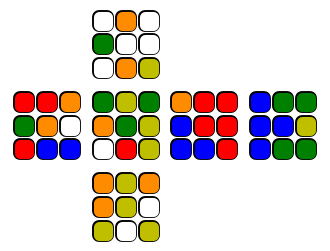

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking arugment for argument mat2 in method wrapper_mm)

In [12]:
def basic_solver(cube, iterations = 20, force_stop = True):
    solution = ""
    last_move = "NO"
    for i in range(iterations):
        ev = evalute_cube(cube)
        move = moves[ev]
#         print(move)
        if force_stop and move[0] == last_move[0]:
            cube.apply_moves(inverse_alg(last_move))
            break
        last_move = move
        solution += move+" "
        cube.apply_moves(move)
    return solution[:-3]
        

N = 18
scr = gen_random_alg(N)
print("Scramble:",scr)
cube = Cube()
cube.apply_moves(scr)
cube.plot()
solution = basic_solver(cube, iterations = 30, force_stop = False)
print("Solution:",solution)
cube.plot()

In [ ]:
def basic_solver_2(cube, iterations = 20, force_stop = True):
    solution = ""
    last_move = "NO"
    for i in range(iterations):
        alg = lookup_solver(cube)
        if alg:
            cube.apply_moves(alg)
            return solution + alg
        ev = evalute_cube(cube)
        move = moves[ev]
        if force_stop and move[0] == last_move[0]:
            cube.apply_moves(inverse_alg(last_move))
            break
        last_move = move
        solution += move+" "
        cube.apply_moves(move)
    alg = lookup_solver(cube)
    if alg:
        cube.apply_moves(alg)
        return solution + alg
    return solution[:-3]
        

N = 12
scr = gen_random_alg(N)
print("Scramble:",scr)
cube = Cube()
cube.apply_moves(scr)
cube.plot()
solution = basic_solver(cube, iterations = 30, force_stop = False)
print("Solution:",solution)
cube.plot()

## Full Solver 1

Idea:
Take a scrambled cube, use the network to predict some moves that we branch on.
Use table lookup for the m last moves (m = 7?).
Quick overview! For each state in the solution, do the following:
* Check if the state exist in the table lookup. If it does, return the solution + table lookup solution
* Discard solutions where the predicted move is the inverse of the previous move, and solutions where the last three moves are the same base move (R R R2 for example)
* Use AI to predict some different moves, repeat the steps above for each branch (move)

Input
* cube: scrambled cube
* Branching factor k: For each step, look at the k best predicted moves (should be 2 or 3)
* smart_branching: If True, only branch on moves from different axis, if False pick them at random


### Table Lookup

In [13]:
# load table for table lookup
import pickle
with open('dict6.pkl', 'rb') as f:
    table = pickle.load(f)

In [14]:
def lookup_solver(cube):
    '''
    assumes there is some "table" to use
    '''
    ID = id_from_state(cube.state)
    if ID in table.keys():
        alg = table[ID]
#         cube.apply_moves(alg)
        return alg
    return False
        
cube = Cube()
cube.apply_moves("R U R' F L F")
lookup_solver(cube)

"F' L' F' R U' R'"

In [23]:
def branch(cube, k = 2, smart_branching = True):
    '''
    k: branching factor
    smart_branching: if True, don't accept moves along the same layer. I.e. if R then R', replace R' with next
    
    returns the indexes of the moves in question
    '''
    state_tensor = cube_to_tensor(cube)
    output = network(state_tensor)
    if smart_branching:
        sorted_move_indexes = output.sort()[1]
        move_indexes = np.zeros(k, dtype = int)
        move_indexes[0] = sorted_move_indexes[-1]
        used_axes = [move_indexes[0]//3]
        j = 1
        for i in range(1,18): # 18 moves, first is already added
            idx = sorted_move_indexes[-i]
            if idx//3 not in used_axes:
                used_axes.append(idx//3)
                move_indexes[j] = idx
                j+=1
            if j==k:
                break
    else:
        move_indexes = torch.flip(output.sort()[1][-k:],dims=[-1]).numpy() 
    return [moves[i] for i in move_indexes]


scr = "F' U2 R U2 B' L2 U2 L B D' L D L U' D2 L B2 R'"
cube = Cube()
cube.apply_moves(scr)
branch(cube)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking arugment for argument mat2 in method wrapper_mm)

In [ ]:
TEST = [0,0]

def AI_branch_solver(cube, it = 5, k = 2, smart_branching = True, plot = False, last_moves = ["k","l"]):
    '''
    cube: scrambled cube
    k: branching factor
    smart_branching: if True, don't accept moves along the same layer. I.e. if R then R', replace R' with next
    '''
    alg = lookup_solver(cube)
    if alg:
        cube.apply_moves(alg)
        return alg
    if it == 0:
#         print("test",TEST[0])
#         cube.plot()
        return False
    
    branch_moves = branch(cube,k,smart_branching)
    
    for i in range(k):
        new_move = branch_moves[i]
        inv = inverse_alg(new_move)
        # check that this move does not cancel the last one, and that it does not move along the same axis as the previous two moves
        if (inv[0] != last_moves[0][0]):# and (new_move[0]!=last_moves[0][0] or new_move[0]!=last_moves[1][0]):
            cube.apply_moves(new_move)
            TEST[0]+=1
            sol = AI_branch_solver(cube, it-1, k, smart_branching, last_moves = [new_move,last_moves[0]])
            if cube.is_solved():
                return new_move+" "+sol
            cube.apply_moves(inv)
        else:
            TEST[1]+=1
    return False

it = 4
k = 2
scr = gen_random_alg(10)
cube = Cube()
print("Scramble:",scr)
cube.apply_moves(scr)
# cube.plot()
sol = AI_branch_solver(cube, it=it, k=k, smart_branching=True)
print("Solution:",sol)
# cube.plot()
TEST

## Full Solver 2

Idea:
Solve the cube in "3" steps:
1. Apply all algs of increasing length (all of length 1, then 2, ...)
2. Use the AI to predict n moves forwards
3. Check if we can solve with lookup every step of the AI

U' L' U2 L F R U' B U2


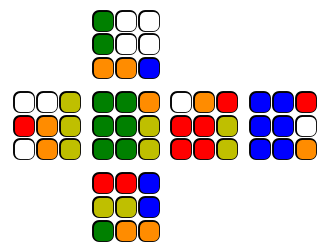

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking arugment for argument mat2 in method wrapper_mm)

In [27]:
def evalute_cube(cube):
    state_tensor = cube_to_tensor(cube)
    output = network(state_tensor)
    _, predicted_class = torch.max(output, dim=0)
    return predicted_class.item()

def AI_linear_solver(cube, iterations = 10):
    solution = ""
    last_move = "NO"
    for i in range(iterations):
        alg = lookup_solver(cube)
        if alg:
            cube.apply_moves(alg)
            return solution + alg
        ev = evalute_cube(cube)
        move = moves[ev]
        solution += move+" "
        cube.apply_moves(move)
    alg = lookup_solver(cube)
    if alg:
        cube.apply_moves(alg)
        return solution + alg
    else:
        cube.apply_moves(inverse_alg(solution.strip()))
    return False


def epic_solver(cube, AI_iterations = 10, algs = [""]):
    '''
    cube: scrambled cube that we want solved
    AI_iterations: nr of iterations for the AI
    cutoff: stop generating scrambles at this point
    '''
    
    # check if AI + table lookup solves this case
    sol0 = AI_linear_solver(cube,AI_iterations)
    if sol0:
        return sol0
    TEST = 0
    for alg in algs:
        TEST+=1
        inv = inverse_alg(alg)
        cube.apply_moves(alg)
        sol0 = AI_linear_solver(cube,AI_iterations)
        if sol0:
            print(TEST)
            return alg+" "+sol0
        cube.apply_moves(inv)
    return False
     
    
scr = inverse_alg("U2 B' U R' F' L' U2 L U") #gen_random_alg(10)
cube = Cube()
cube.apply_moves(scr)
print(scr)
cube.plot()
sol = epic_solver(cube, algs = algs)
print(sol)

In [25]:
scr = gen_random_alg(10)
algs = gen_all_algs(3)
# t = time.time()
# for i in range(1000):
#     AI_linear_solver(cube)
#     if cube.is_solved():
#         print("HEY")
# print(time.time()-t)

1 genned in 0.0
2 genned in 0.0009996891021728516
3 genned in 0.014570951461791992


In [ ]:
# test cstimer scrambles
with open("100scrambles.txt","r") as f:
    scrambles = f.read().split("\n")[:-1]

for i in range(len(scrambles)):
    scrambles[i] = scrambles[i].strip()
    
for i,scr in enumerate(scrambles):
    cube = Cube()
    cube.apply_moves(scr)
#     cube.plot()
    sol = epic_solver(cube, algs = algs)
    print(f"Scramble {i+1}:",scr,"Solution:",sol)

Reinforced learning Kristian: Hvis løsbar for alle N, gen blandinger av lengde N+1. De den ikke løser bruker jeg som treningsdata opp til et punkt (f.eks 75% accuracy?)

In [ ]:
cube = Cube()
cube.apply_moves("M2 U' M2 U' M' U2 M2 U2 M' F B' D R D' F' B U' R' F R F'")
cube.plot()

